In [478]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss

sympy.init_printing()

In [479]:
def matrix(S0, paths, lam, sigma, mu, v, m, T, I):
    np.random.seed(42)
    df = np.exp(-mu*T)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)
        
        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
    
            if N == 0:
                M = 0
    
            else:
                for j in range(N):
                    M = np.sum(np.log(Y))
                    
            X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z + M
            S[i] = np.exp(X[i])
        matrix[k] = S
    return matrix


# drop model

def drop(S0, paths, lam, sigma, mu, v, m, T, I):
    np.random.seed(42)
    df = np.exp(-mu*T)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)

        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
    
            if N == 0 and X[i-1] > 0:
                X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z
                S[i] = np.exp(X[i])
            else:
                S[i] = 0
        matrix[k] = S
    return matrix

In [480]:
#S_GBM = matrix(S0, paths, lam=0, sigma=0.04, mu=0.06, v=0)
#S_Merton = matrix(S0, paths, lam=2, sigma=0.02, mu=0.06, v=0.02)
#S_Drop = drop(S0, paths, lam=0.05, sigma=0.03, mu=0.07)
#print(S_GBM.shape, S_Merton.shape, S_Drop.shape)

# LSM pricing algorithm

In [481]:
def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1] # set value at maturity equal to intrinsic value
    np.random.seed(1)
    # Valuation by LS Method
    for t in range(I - 2, 0, -1): #start at t = I-2 and go backwards (since we already set t = I-1 to intrinsic value)
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive
        # the regression is performed only on these paths
        if basis == 'poly':
            if np.sum(good_paths) > 0:
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            else:
                continue
        elif basis == 'legendre':
            if np.sum(good_paths) > 0:
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            else:
                continue
        elif basis =='laguerre':
            if np.sum(good_paths) > 0:
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:
                continue
        else:
            if np.sum(good_paths) > 0:
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)
            else:
                continue

        exercise = np.zeros(len(good_paths), dtype=bool)  # initialize
        exercise[good_paths] = H[good_paths, t] > C  # paths where it is optimal to exercise

        V[exercise, t] = H[exercise, t]  # set V equal to H where it is optimal to exercise
        V[exercise, t + 1 :] = 0  # set future cash flows, for that path, equal to zero
        discount_path = V[:, t] == 0  # paths where we didn't exercise
        V[discount_path, t] = V[discount_path, t + 1] * df  # set V[t] in continuation region

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    return V0, V0_array, SE

In [482]:
deg = 3
basis = 'legendre'
#initial price list
S0_list = np.arange(97, 104 , 1)
K = 100

# Simulation

In [483]:
mu = 0.02
T = 1
I = 250
paths = 1000
m = 0

GBM_lam = 0
GBM_sigma = 0.04
GBM_mu = mu
GBM_v = 0

Merton_lam = 1
Merton_sigma = 0.02
Merton_mu = mu
Merton_v = 0.02

Drop_lam = 0.01
Drop_sigma = 0.03
Drop_mu = 0.01

df = np.exp(-mu*T)

In [484]:
GBM = matrix(100, paths, lam=GBM_lam, sigma=GBM_sigma, mu=GBM_mu, v=GBM_v, m=m, T=T, I=I)
Merton = matrix(100, paths, lam=Merton_lam, sigma=Merton_sigma, mu=Merton_mu, v=Merton_v, T=T, I=I, m=m)
Drop = drop(100, paths, lam=Drop_lam, sigma=Drop_sigma, mu=Drop_mu, T=T, I=I, m=m, v=0)

GBM_price, GBM_V, SE_GBM = LSM(K, GBM, I, df, basis, deg)
Merton_price, Merton_V, SE_Merton = LSM(K, Merton, I, df, basis, deg)
Drop_price, Drop_V, SE_Drop = LSM(K, Drop, I, df, basis, deg)

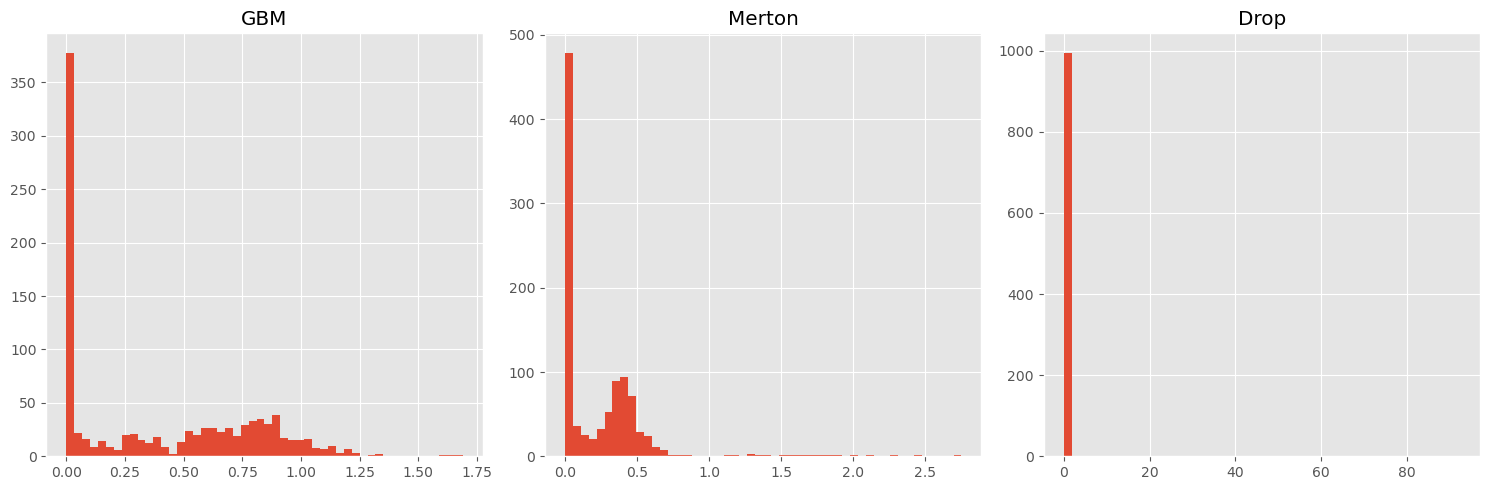

In [485]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) # Adjust the figsize as needed

axes[0].hist(GBM_V, bins=50)
axes[0].set_title('GBM')

axes[1].hist(Merton_V, bins=50)
axes[1].set_title('Merton')

axes[2].hist(Drop_V, bins=50)
axes[2].set_title('Drop')

plt.tight_layout() # This ensures that the subplots fit nicely in the figure area
plt.show()

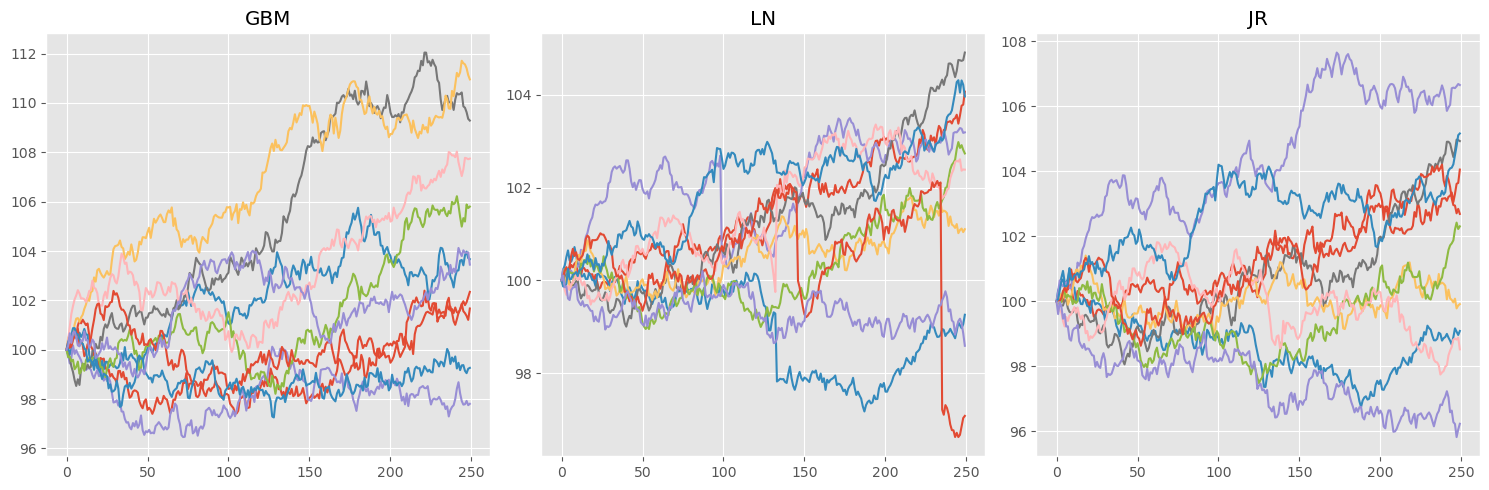

In [486]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) # Adjust the figsize as needed

#plot the first 10 paths
for i in range(10):
    axes[0].plot(GBM[i])
    axes[0].set_title('GBM')

    axes[1].plot(Merton[i])
    axes[1].set_title('LN')

    axes[2].plot(Drop[i])
    axes[2].set_title('JR')

plt.tight_layout() # This ensures that the subplots fit nicely in the figure area
plt.show()


In [487]:
# Containers for storing matrices
GBM_matrices = {}
Merton_matrices = {}
Drop_matrices = {}

# Containers for storing prices
GBM_prices = []
Merton_prices = []
Drop_prices = []

GBM_SE = []
Merton_SE = []
Drop_SE = []

# Generate matrices and calculate prices for each S0 in S0_list
for S0 in S0_list:
    # Generate matrices
    GBM_matrices[S0] = matrix(S0, paths, lam=GBM_lam, sigma=GBM_sigma, mu=GBM_mu, v=GBM_v, m=m, T=T, I=I)
    Merton_matrices[S0] = matrix(S0, paths, lam=Merton_lam, sigma=Merton_sigma, mu=Merton_mu, v=Merton_v, T=T, I=I, m=m)
    Drop_matrices[S0] = drop(S0, paths, lam=Drop_lam, sigma=Drop_sigma, mu=Drop_mu, T=T, I=I, m=m, v=0)

    # Calculate prices for each stock model
    GBM_price, GBM_V, SE_GBM = LSM(K, GBM_matrices[S0], I, df, basis, deg)
    Merton_price, Merton_V, SE_Merton = LSM(K, Merton_matrices[S0], I, df, basis, deg)
    Drop_price, Drop_, SE_Drop = LSM(K, Drop_matrices[S0], I, df, basis, deg)

    # Store the prices
    GBM_prices.append(GBM_price)
    Merton_prices.append(Merton_price)
    Drop_prices.append(Drop_price)

    #store the standard errors
    GBM_SE.append(SE_GBM)
    Merton_SE.append(SE_Merton)
    Drop_SE.append(SE_Drop)

/Users/philipgadereumert/opt/anaconda3/lib/python3.9/site-packages/numpy/polynomial/legendre.py:1411: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


In [488]:
#print the H matrix for each model
#display_matrix(GBM_matrices[100]) 
#display_matrix(Merton_matrices[100])
#display_matrix(Drop_matrices[100])


# European Closed

In [489]:
def closed_formula_GBM(S0, mu, sigma, T, K):
    """
    Black Scholes closed formula:
    """
    d1 = (np.log(S0 / K) + (mu + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-mu * T) * ss.norm.cdf(-d2) - S0 * ss.norm.cdf(-d1)

def closed_formula_GBM_call(S0, mu, sigma, T, K):
    """
    Black Scholes closed formula:
    """
    d1 = (np.log(S0 / K) + (mu + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * ss.norm.cdf(d1) - K * np.exp(-mu * T) * ss.norm.cdf(d2)

def closed_formula_Merton(S0):
    m = Merton_lam * (np.exp(Merton_mu + (Merton_sigma**2) / 2) - 1)
    lam2 = Merton_lam * np.exp(Merton_mu + Merton_sigma**2) / 2
    v = Merton_v

    tot = 0
    for k in range(18):
        tot += (np.exp(-lam2 * T) * (lam2 * T) ** k / np.math.factorial(k)) * closed_formula_GBM(
        S0,
        Merton_mu - m + k * (Merton_mu + 0.5 * Merton_sigma**2) / T,
        np.sqrt(Merton_sigma**2 + k * v**2 / T),
        T,
        K
        )
        return tot
    
def closed_formula_Call_Drop(S0):
    return np.exp(-Drop_lam * T) * closed_formula_GBM_call(S0, Drop_mu, Drop_sigma, T, K)

def closed_formula_Put_Drop(S0):
    return closed_formula_Call_Drop(S0) - S0 + K * np.exp(-Drop_mu * T)

In [490]:
##calculate the standard errors for each simulation
#GBM_std = np.std(GBM_prices) / np.sqrt(len(GBM_prices))
#Merton_std = np.std(Merton_prices) / np.sqrt(len(Merton_prices))
#Drop_std = np.std(Drop_prices) / np.sqrt(len(Drop_prices))
#
#GBM_se = GBM_std / np.sqrt(len(GBM_prices))
#Merton_se = Merton_std / np.sqrt(len(Merton_prices))
#Drop_se = Drop_std / np.sqrt(len(Drop_prices))
#
#print('Standard errors:')
#print('GBM: ', GBM_se)
#print('Merton: ', Merton_se)
#print('Drop: ', Drop_se)

In [491]:
# Print the V0 price for each model and each S0
for i, S0 in enumerate(S0_list):
    print(f"S0 = {S0}:")
    print(f"  GBM Price: {GBM_prices[i]},   se = {GBM_SE[i]}")
    print(f"  Merton Price: {Merton_prices[i]},  se = {Merton_SE[i]}")
    print(f"  Drop Price: {Drop_prices[i]}, se = {Drop_SE[i]}")
    print(f"  European_GBM: {closed_formula_GBM(S0, GBM_mu, GBM_sigma, T, K)}")
    print(f"  European_Merton: {closed_formula_Merton(S0)}")
    print(f"  European_Drop: {closed_formula_Put_Drop(S0)}")
    print()

S0 = 97:
  GBM Price: 2.928488851288782,   se = 0.007946620589865025
  Merton Price: 2.9353543381889926,  se = 0.006184789099193206
  Drop Price: 2.9818335422855466, se = 0.0897944071842067
  European_GBM: 2.118745615167974
  European_Merton: 1.856664264805681
  European_Drop: 2.4336746648261425

S0 = 98:
  GBM Price: 1.9481653618105306,   se = 0.008028544513471889
  Merton Price: 1.9561781680811758,  se = 0.005818286408141691
  Drop Price: 2.0070715896712095, se = 0.09076835033128017
  European_GBM: 1.5738617406084288
  European_Merton: 1.3184061133164857
  European_Drop: 1.7414688568398162

S0 = 99:
  GBM Price: 0.9871307684103934,   se = 0.010606897005493509
  Merton Price: 0.9789687419702348,  se = 0.005200909981320226
  Drop Price: 1.0856285676940265, se = 0.11851399341123119
  European_GBM: 1.1301920187930676
  European_Merton: 0.8526937136501547
  European_Drop: 1.1755726989986357

S0 = 100:
  GBM Price: 0.4012786957944024,   se = 0.012500567640695154
  Merton Price: 0.229973373

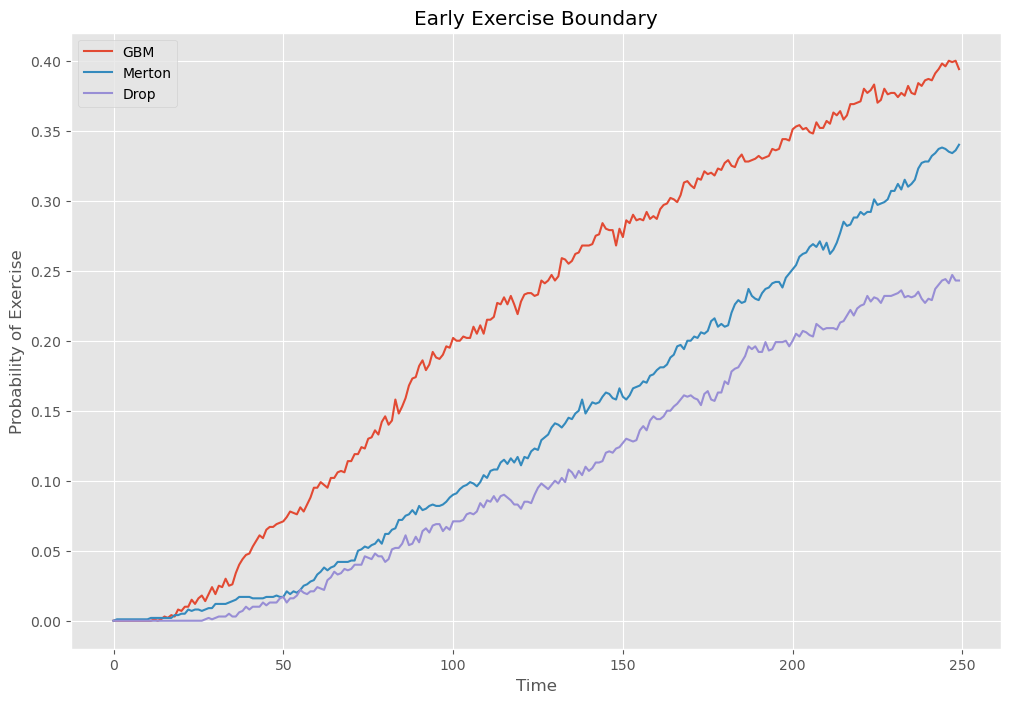

In [492]:
#plot the early exercise boundary for each model

#GBM
GBM_EEB = []
for S0 in S0_list:
    GBM_EEB.append(np.mean(GBM_matrices[S0] > K, axis=0))
GBM_EEB = np.array(GBM_EEB)

#Merton
Merton_EEB = []
for S0 in S0_list:
    Merton_EEB.append(np.mean(Merton_matrices[S0] > K, axis=0))
Merton_EEB = np.array(Merton_EEB)

#Drop
Drop_EEB = []
for S0 in S0_list:
    Drop_EEB.append(np.mean(Drop_matrices[S0] > K, axis=0))
Drop_EEB = np.array(Drop_EEB)

#plot the early exercise boundary for each model
plt.figure(figsize=(12,8))
plt.plot(np.arange(I), GBM_EEB[0], label='GBM')
plt.plot(np.arange(I), Merton_EEB[0], label='Merton')
plt.plot(np.arange(I), Drop_EEB[0], label='Drop')
plt.legend()
plt.title('Early Exercise Boundary')
plt.xlabel('Time')
plt.ylabel('Probability of Exercise')
plt.show()

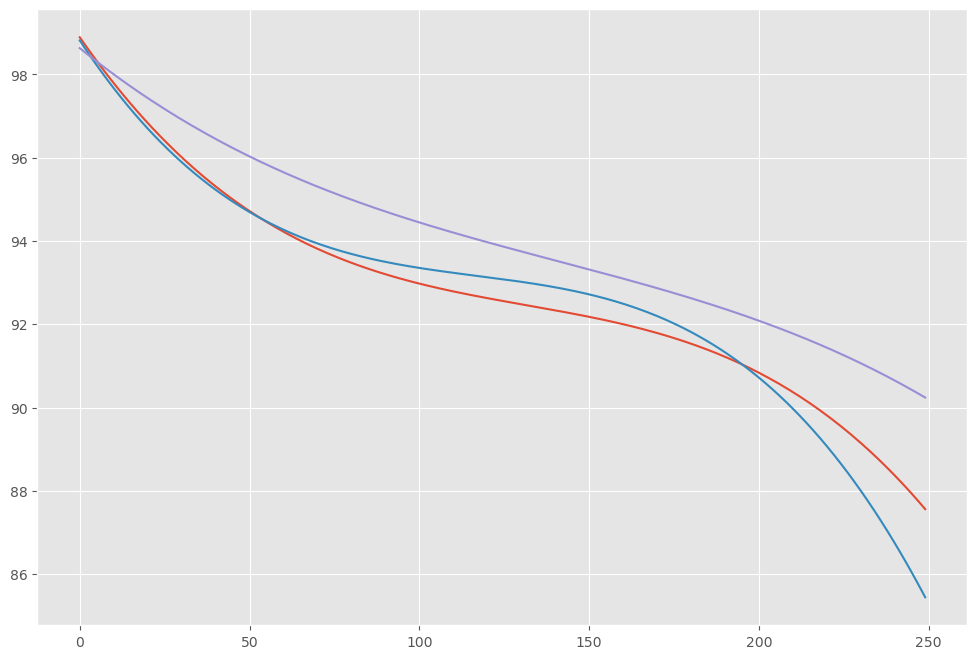

In [493]:
def find_early_exercise_boundary(V, S):
    boundary = np.full(V.shape[1], np.nan)
    for t in range(V.shape[1]):
        exercised_paths = V[:, t] > 0
        if np.any(exercised_paths):
            boundary[t] = np.min(S[exercised_paths, t])
    return boundary

#fit a polynomial to the early exercise boundary
def fit_polynomial(S0, V, S, deg):
    boundary = find_early_exercise_boundary(V, S)
    t = np.arange(len(boundary))
    good_paths = ~np.isnan(boundary)
    rg = np.polyfit(t[good_paths], boundary[good_paths], deg)
    return rg

#plot a polynomial at S0 = 100 for each model. Start at 
plt.figure(figsize=(12,8))
rg = fit_polynomial(100, GBM_matrices[100], GBM_matrices[100], deg)
plt.plot(np.arange(I), np.polyval(rg, np.arange(I)), label='GBM')
rg = fit_polynomial(100, Merton_matrices[100], Merton_matrices[100], deg)
plt.plot(np.arange(I), np.polyval(rg, np.arange(I)), label='Merton')
rg = fit_polynomial(100, Drop_matrices[100], Drop_matrices[100], deg)
plt.plot(np.arange(I), np.polyval(rg, np.arange(I)), label='Drop')


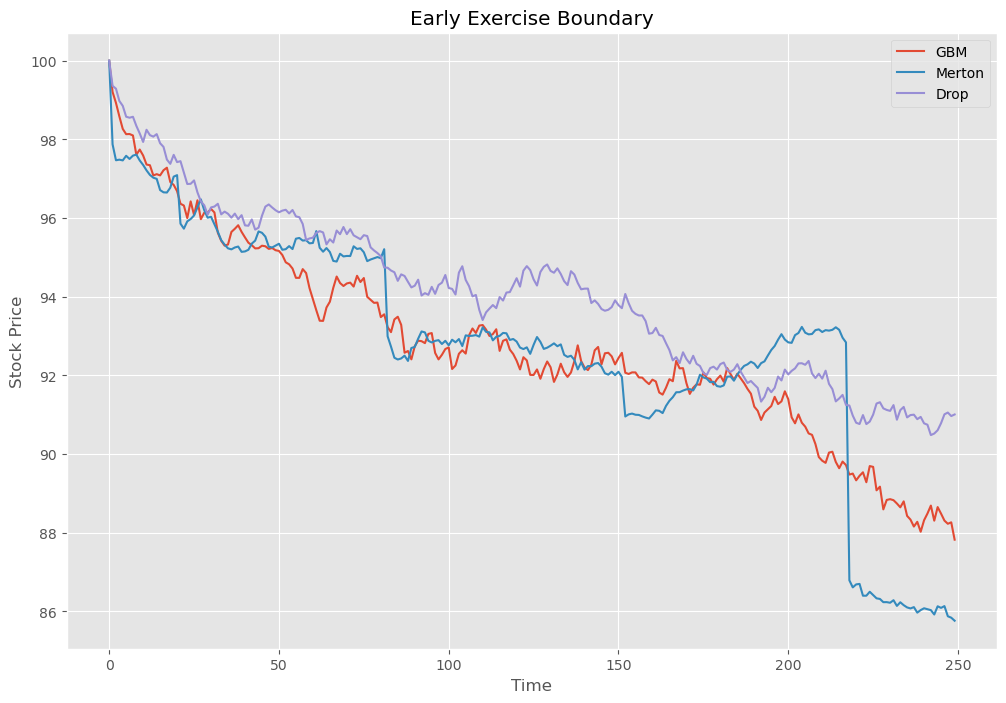

In [494]:
#plot the early exercise boundary for each model
plt.figure(figsize=(12,8))
plt.plot(np.arange(I), find_early_exercise_boundary(GBM_matrices[100], GBM_matrices[100]), label='GBM')
plt.plot(np.arange(I), find_early_exercise_boundary(Merton_matrices[100], Merton_matrices[100]), label='Merton')
plt.plot(np.arange(I), find_early_exercise_boundary(Drop_matrices[100], Drop_matrices[100]), label='Drop')
plt.legend()
plt.title('Early Exercise Boundary')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

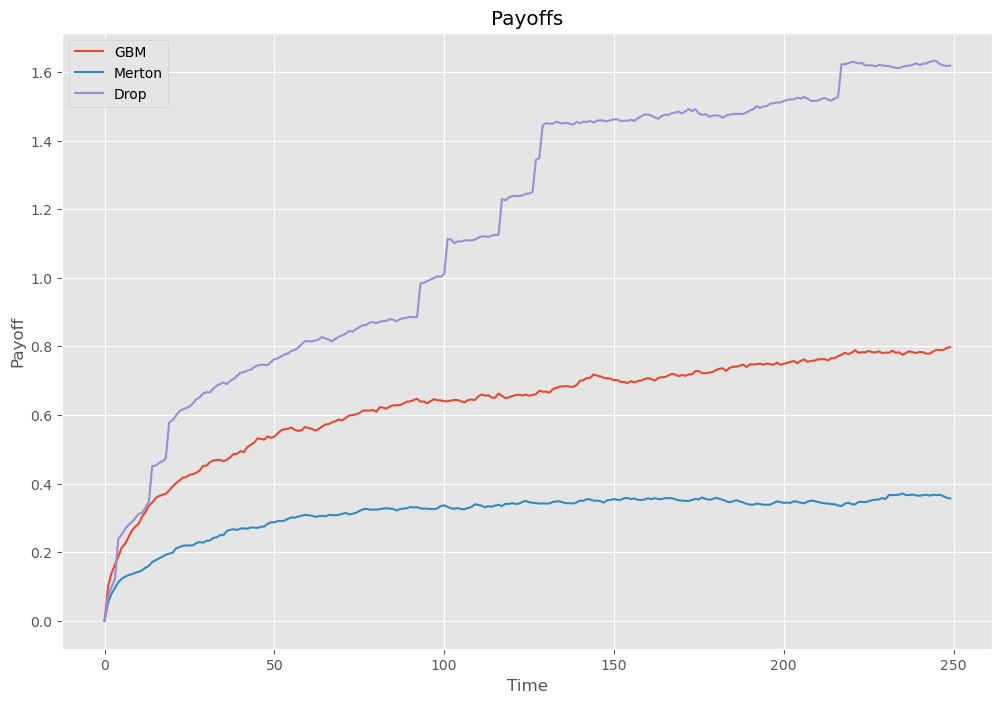

In [495]:
#plot payoffs
plt.figure(figsize=(12,8))
plt.plot(np.arange(I), np.mean(np.maximum(K - GBM_matrices[100], 0), axis=0), label='GBM')
plt.plot(np.arange(I), np.mean(np.maximum(K - Merton_matrices[100], 0), axis=0), label='Merton')
plt.plot(np.arange(I), np.mean(np.maximum(K - Drop_matrices[100], 0), axis=0), label='Drop')
plt.legend()
plt.title('Payoffs')
plt.xlabel('Time')
plt.ylabel('Payoff')
plt.show()

In [496]:
#control variate
